Dataset: 
Single, S., Iranmanesh, S., & Raad, R. (2023). RealWaste [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5SS4G.

In [12]:
import tensorflow as tf 
from tensorflow.keras import datasets, layers, models, Input
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


In [3]:
def results(history, epochs):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(fine_tune_epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [4]:
def conf_mat(train_ds, val_ds, model):

    #Makes the confusion matrix

    class_names = train_ds.class_names
    print("Class names:", class_names)

    # Convert dataset to numpy arrays (true labels)
    y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0)

    print("Shape of y_true:", y_true.shape)
    print("Example labels:", y_true[:10])

    label_map = {i: name for i, name in enumerate(class_names)}
    print("Label map:", label_map)
    y_true_names = [label_map[label] for label in y_true]

    y_pred = model.predict(val_ds)
    y_pred_classes = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_true, y_pred_classes)
    print(cm)

    #Making the confusion matrix easier to read
    plt.figure(figsize=(9, 9))
    sns.heatmap(cm, annot=True, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    print(classification_report(y_true, y_pred))


In [ ]:
def p2(base_model, model, train_ds, val_ds, epochs, history):
    
    #Transfer learning Phase II

    # Unfreeze only the *last 30 layers* 
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    for layer in base_model.layers[-30:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # MUCH lower LR
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )

    
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        verbose=1
    )

In [5]:

#Load in and preprocess data

data_dir = r'C:\Users\Admin\Downloads\realwaste\realwaste-main\RealWaste'

batch_size = 32
img_height = 224
img_width = 224
IMG_SIZE = (224, 224)

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  )

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle = False
  )


Found 4752 files belonging to 9 classes.
Using 3802 files for training.
Found 4752 files belonging to 9 classes.
Using 950 files for validation.


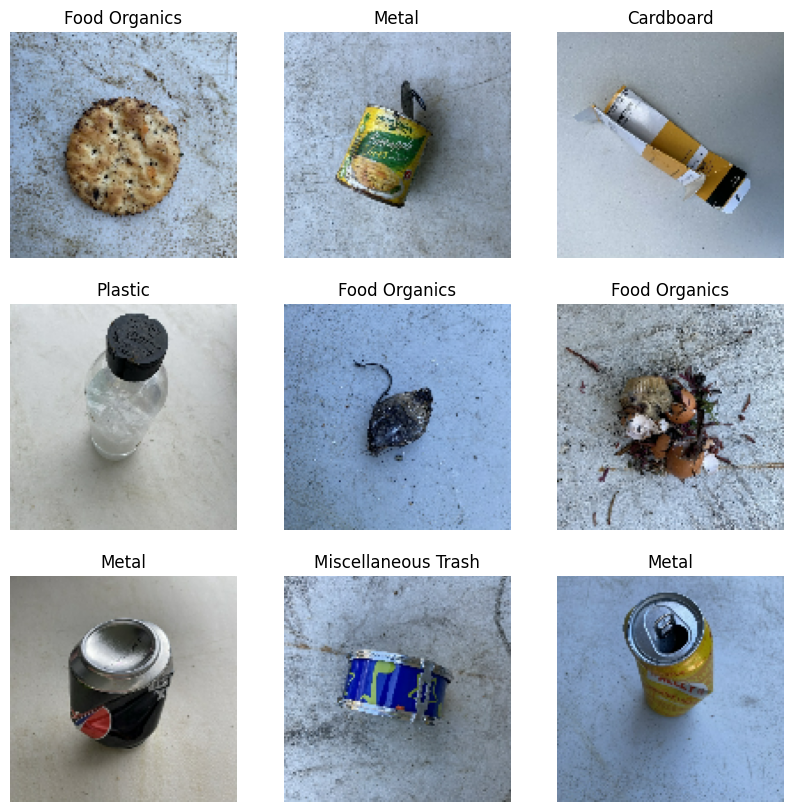

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [147]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.1, 0.1)
])

Model from scratch

In [177]:
#Custom made approach

model = models.Sequential()
model.add(layers.Rescaling(1./255)),
model.add(data_augmentation),
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128,128,3))),
model.add(layers.BatchNormalization()),
model.add(layers.MaxPooling2D((2, 2))),

model.add(layers.Conv2D(64, (3, 3), activation='relu')),
model.add(layers.BatchNormalization()),

model.add(layers.MaxPooling2D((2, 2))),

model.add(layers.Conv2D(128, (3, 3), activation='relu')),
model.add(layers.BatchNormalization()),

model.add(layers.MaxPooling2D((2, 2))),

model.add(layers.Conv2D(256, (3, 3), activation='relu')),
model.add(layers.BatchNormalization()),

model.add(layers.MaxPooling2D((2, 2))),

model.add(layers.Flatten()),
model.add(layers.Dense(256, activation='relu')),
model.add(layers.Dropout(0.4)),
model.add(layers.Dense(9, activation='softmax'))


lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
)

Epoch 1/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.3843 - loss: 2.0541 - val_accuracy: 0.0663 - val_loss: 5.5780
Epoch 2/5
 70/119 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - accuracy: 0.4709 - loss: 1.5416

KeyboardInterrupt: 

ResNet50

In [216]:


#Transfer Learning approach

# Create the base model from the pre-trained model ResNet50
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=9,
    classifier_activation="softmax",
    name="resnet50v2",
)
base_model.trainable = False  # Freeze pretrained layers

# Build the classification model
model = models.Sequential([
    layers.Rescaling(1./255),
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),      # Flatten feature maps
    layers.Dropout(0.3),                  # Regularization
    layers.Dense(9, activation='softmax') # 9 output classes
])


model.compile(optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy'])


epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
    verbose = 1
)

Epoch 1/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.4895 - loss: 1.4997 - val_accuracy: 0.7926 - val_loss: 0.6236
Epoch 2/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.6604 - loss: 0.9820 - val_accuracy: 0.8147 - val_loss: 0.5653
Epoch 3/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - accuracy: 0.6983 - loss: 0.8499 - val_accuracy: 0.8379 - val_loss: 0.4860
Epoch 4/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.7280 - loss: 0.7699 - val_accuracy: 0.8611 - val_loss: 0.4152
Epoch 5/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.7483 - loss: 0.7280 - val_accuracy: 0.8737 - val_loss: 0.3975


In [217]:
#Transfer learning Phase II

# Unfreeze only the *last 30 layers* 
for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True



model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # MUCH lower LR
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

fine_tune_epochs = 5
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=fine_tune_epochs,
    verbose=1
)

Epoch 1/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 316s 3s/step - accuracy: 0.7722 - loss: 0.6413 - val_accuracy: 0.8695 - val_loss: 0.3918
Epoch 2/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 307s 3s/step - accuracy: 0.7964 - loss: 0.5656 - val_accuracy: 0.8947 - val_loss: 0.3150
Epoch 3/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - accuracy: 0.8298 - loss: 0.4873 - val_accuracy: 0.9168 - val_loss: 0.2521
Epoch 4/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - accuracy: 0.8351 - loss: 0.4699 - val_accuracy: 0.9074 - val_loss: 0.2938
Epoch 5/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 328s 3s/step - accuracy: 0.8443 - loss: 0.4223 - val_accuracy: 0.9126 - val_loss: 0.2766


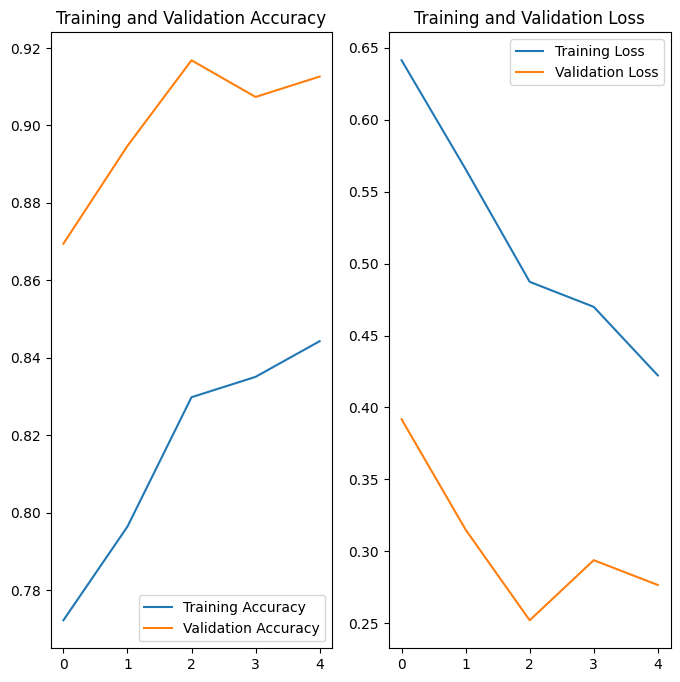

In [218]:
results(history_finetune, fine_tune_epochs)

InceptionV3

In [9]:
#Load in and preprocess data

data_dir = r'C:\Users\Admin\Downloads\realwaste\realwaste-main\RealWaste'

batch_size = 32
img_height = 229
img_width = 229
IMG_SIZE = (229, 229)

train_ds_inc = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds_inc = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 4752 files belonging to 9 classes.
Using 3802 files for training.
Found 4752 files belonging to 9 classes.
Using 950 files for validation.


In [10]:

IMG_SHAPE = IMG_SIZE + (3,)

inc_base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classifier_activation="softmax",
    name="inception_v3",
)

inc_base_model.trainable = False  # Freeze pretrained layers

# Build the classification model
inc_model = models.Sequential([
    layers.Rescaling(1./255),
    #data_augmentation,
    inc_base_model,
    layers.GlobalAveragePooling2D(),      # Flatten feature maps
    layers.Dropout(0.3),                  # Regularization
    layers.Dense(9, activation='softmax') # 9 output classes
])


inc_model.compile(optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy'])

fine_tune_epochs = 5
history_finetune = inc_model.fit(
    train_ds_inc,
    validation_data=val_ds_inc,
    epochs=fine_tune_epochs,
    verbose=1
)

Epoch 1/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.4921 - loss: 1.4679 - val_accuracy: 0.6537 - val_loss: 0.9447
Epoch 2/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.6846 - loss: 0.8996 - val_accuracy: 0.7253 - val_loss: 0.7801
Epoch 3/5
 15/119 ━━━━━━━━━━━━━━━━━━━━ 1:32 893ms/step - accuracy: 0.7253 - loss: 0.7675

KeyboardInterrupt: 

In [202]:
#Transfer learning Phase II

# Unfreeze only the *last 30 layers* 
for layer in inc_base_model.layers[:-30]:
    layer.trainable = False
for layer in inc_base_model.layers[-30:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

inc_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # MUCH lower LR
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

fine_tune_epochs = 5
history_finetune = inc_model.fit(
    train_ds_inc,
    validation_data=val_ds_inc,
    epochs=fine_tune_epochs,
    verbose=1
)

Epoch 1/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.8264 - loss: 0.4983 - val_accuracy: 0.7695 - val_loss: 0.6587
Epoch 2/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.8546 - loss: 0.4293 - val_accuracy: 0.7695 - val_loss: 0.6487
Epoch 3/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.8698 - loss: 0.3778 - val_accuracy: 0.7779 - val_loss: 0.6251
Epoch 4/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.8961 - loss: 0.3229 - val_accuracy: 0.7821 - val_loss: 0.6183
Epoch 5/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.9124 - loss: 0.2871 - val_accuracy: 0.7853 - val_loss: 0.6104


Class names: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Shape of y_true: (950,)
Example labels: [6 8 1 3 8 3 0 3 8 6]
Label map: {0: 'Cardboard', 1: 'Food Organics', 2: 'Glass', 3: 'Metal', 4: 'Miscellaneous Trash', 5: 'Paper', 6: 'Plastic', 7: 'Textile Trash', 8: 'Vegetation'}
30/30 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step
[[15  3  2 17  7  3 20  8  8]
 [19  2  4 12  4  3 21  8  5]
 [ 9  5  2 12  3  4 13  3 12]
 [41  8  6 31  6  4 39 11 24]
 [21  3  2 16  7 10 26  5 15]
 [13  6  2 17  5 12 15  6 12]
 [50  9  7 26 10  9 49 15 23]
 [14  5  1  8  3  3 17  4  8]
 [25  9  1 17  4  9 20  8  9]]


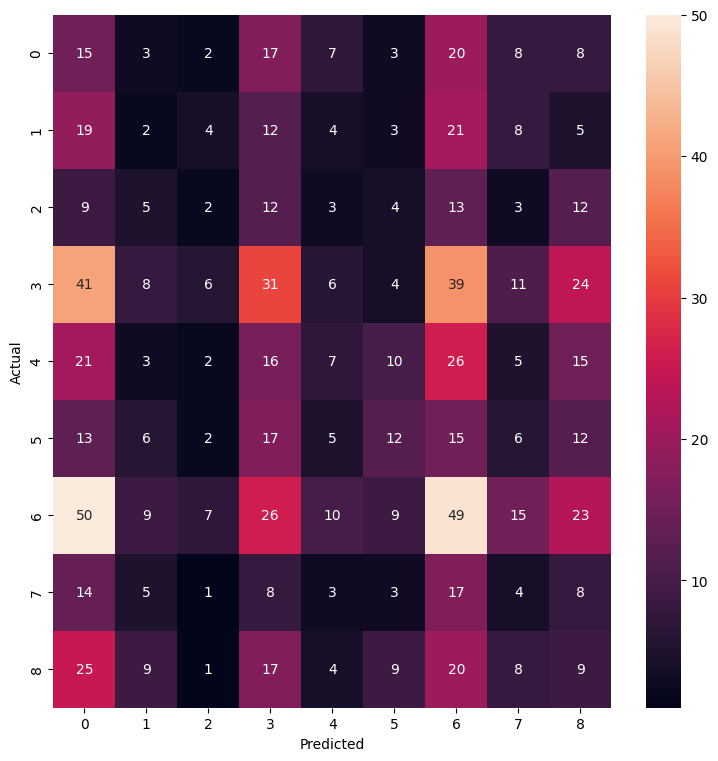

ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets

In [13]:
#Makes the confusion matrix

class_names = train_ds_inc.class_names
print("Class names:", class_names)

# Convert dataset to numpy arrays (true labels)
y_true = np.concatenate([y.numpy() for x, y in val_ds_inc], axis=0)

print("Shape of y_true:", y_true.shape)
print("Example labels:", y_true[:10])
label_map = {i: name for i, name in enumerate(class_names)}
print("Label map:", label_map)
y_true_names = [label_map[label] for label in y_true]

y_pred = inc_model.predict(val_ds_inc).round()
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
print(cm)

    #Making the confusion matrix easier to read
plt.figure(figsize=(9, 9))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_true, y_pred))

VGG16

In [204]:
IMG_SHAPE = IMG_SIZE + (3,)

vgg_base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classifier_activation="softmax",
    name="vgg16",
)

vgg_base_model.trainable = False  # Freeze pretrained layers

# Build the classification model
vgg_model = models.Sequential([
    layers.Rescaling(1./255),
    #data_augmentation,
    vgg_base_model,
    layers.GlobalAveragePooling2D(),      # Flatten feature maps
    layers.Dropout(0.3),                  # Regularization
    layers.Dense(9, activation='softmax') # 9 output classes
])


vgg_model.compile(optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy'])

fine_tune_epochs = 5
history_finetune = vgg_model.fit(
    train_ds_inc,
    validation_data=val_ds_inc,
    epochs=fine_tune_epochs,
    verbose=1
)



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 571s 5s/step - accuracy: 0.2599 - loss: 1.9970 - val_accuracy: 0.4400 - val_loss: 1.7643
Epoch 2/5
 38/119 ━━━━━━━━━━━━━━━━━━━━ 5:43 4s/step - accuracy: 0.3720 - loss: 1.8012

KeyboardInterrupt: 

In [ ]:
#Transfer learning Phase II

# Unfreeze only the *last 30 layers* 
for layer in vgg_base_model.layers[:-30]:
    layer.trainable = False
for layer in vgg_base_model.layers[-30:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

vgg_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # MUCH lower LR
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

fine_tune_epochs = 5
history_finetune = vgg_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=fine_tune_epochs,
    verbose=1
)

NameError: name 'vgg_base_model' is not defined

MobileNet2


In [ ]:
#Transfer Learning approach

# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model_MN2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False  # Freeze pretrained layers

# Build the classification model
model = models.Sequential([
    layers.Rescaling(1./255),
    #data_augmentation,
    base_model_MN2,
    layers.GlobalAveragePooling2D(),      # Flatten feature maps
    layers.Dropout(0.3),                  # Regularization
    layers.Dense(9, activation='softmax') # 9 output classes
])


model.compile(optimizer=tf.keras.optimizers.SGD(0.2,0.9, 0.01),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy'])


epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
    verbose = 1
)

Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 94s 737ms/step - accuracy: 0.5179 - loss: 14.2056 - val_accuracy: 0.6853 - val_loss: 6.6663
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 86s 724ms/step - accuracy: 0.5989 - loss: 12.0609 - val_accuracy: 0.6726 - val_loss: 9.9179
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 84s 707ms/step - accuracy: 0.6315 - loss: 12.4537 - val_accuracy: 0.7105 - val_loss: 8.0700
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 87s 728ms/step - accuracy: 0.6573 - loss: 11.3932 - val_accuracy: 0.7126 - val_loss: 8.4712
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 83s 698ms/step - accuracy: 0.6604 - loss: 11.5232 - val_accuracy: 0.6758 - val_loss: 11.1819
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 83s 694ms/step - accuracy: 0.6657 - loss: 12.4932 - val_accuracy: 0.7116 - val_loss: 8.9283
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 81s 684ms/step - accuracy: 0.6665 - loss: 12.6065 - val_accuracy: 0.7042 - val_loss: 11.3952
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 81s 679ms/step - accuracy: 0.6704 

In [ ]:
#Transfer learning Phase II

# Unfreeze only the *last 30 layers* of MobileNetV2
for layer in base_model_MN2.layers[:-30]:
    layer.trainable = False
for layer in base_model_MN2.layers[-30:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # MUCH lower LR
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

fine_tune_epochs = 10
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=fine_tune_epochs,
    verbose=1
)

Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 110s 825ms/step - accuracy: 0.1252 - loss: 18.1500 - val_accuracy: 0.0663 - val_loss: 73.0731
Epoch 2/10
 53/119 ━━━━━━━━━━━━━━━━━━━━ 48s 731ms/step - accuracy: 0.1334 - loss: 14.1567

KeyboardInterrupt: 

Class names: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Shape of y_true: (950,)
Example labels: [6 6 6 6 6 6 6 6 6 6]
Label map: {0: 'Cardboard', 1: 'Food Organics', 2: 'Glass', 3: 'Metal', 4: 'Miscellaneous Trash', 5: 'Paper', 6: 'Plastic', 7: 'Textile Trash', 8: 'Vegetation'}
30/30 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step
[[  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [ 16   0  13  16   0   0 151   0   0]
 [ 17   1   0   1  11   5   2 281   0]
 [  3  12   0   0   0   0   0   0 421]]


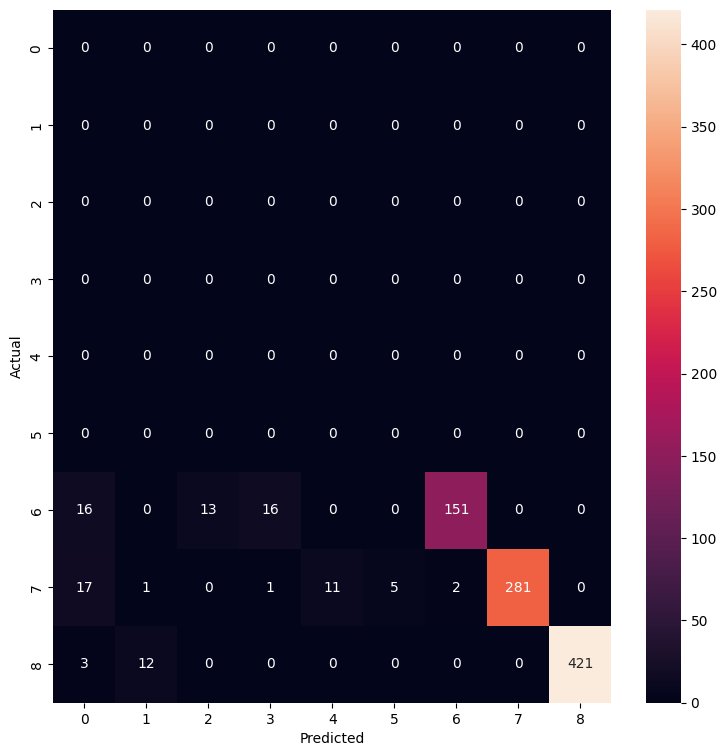

ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets

In [221]:
#Makes the confusion matrix

class_names = train_ds.class_names
print("Class names:", class_names)

# Convert dataset to numpy arrays (true labels)
y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0)

print("Shape of y_true:", y_true.shape)
print("Example labels:", y_true[:10])
label_map = {i: name for i, name in enumerate(class_names)}
print("Label map:", label_map)
y_true_names = [label_map[label] for label in y_true]

y_pred = model.predict(val_ds).round()
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
print(cm)

    #Making the confusion matrix easier to read
plt.figure(figsize=(9, 9))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_true, y_pred))